In [1]:
# IMPORT
from IPython.display import Image, Math

import os
import numpy as np
import pandas as pd
from utils import *
import pyAgrum
import pyAgrum.skbn as skbn
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.image as gimg
import pyAgrum.lib.dynamicBN as gdyn
import pyAgrum.causal as pyc
import pyAgrum.causal.notebook as cslnb
# from pyAgrum.lib.discretizer import Discretizer
import re
from sklearn.cluster import KMeans
# from kneed import KneeLocator
from scipy.stats import iqr, gaussian_kde, entropy
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'  # Set background to white globally
plt.rcParams['axes.facecolor'] = 'white'    # Set axis background to white
import warnings
import pickle
warnings.filterwarnings("ignore")

print(pyAgrum.__version__)

1.13.2


In [2]:
def format_evidence_for_latex(evidence):
    formatted_evidence = []
    
    for var in evidence.keys():
        # Replace the part after the underscore with curly braces, if applicable
        var = re.sub(r'_(\w+)', r'_{\1}', var)  # Add {} around the part after the underscore
        
        # Replace '0' with '_{t-1}'
        var = var.replace('t', '_t')
        var = var.replace('0', '_{t-1}')

        # Append formatted variable to the list
        formatted_evidence.append(f"${var}$")  # Adding $ for LaTeX format
        
    return ', '.join(formatted_evidence)

def plot_distributions(var, distributions, var_midpoints, xlabel, ylabel):
    # Number of distributions to plot
    n = len(distributions)
    
    # Create subplots (one for each distribution)
    fig, axes = plt.subplots(1, n, figsize=(12, 4))

    # If there's only one plot, axes is not a list, so we handle it separately
    if n == 1:
        axes = [axes]
    var_midpoints = [round(float(m),2) for m in var_midpoints]
    for i, (data, title) in enumerate(distributions):
        # Plot the distribution in the corresponding subplot
        axes[i].bar(range(len(data)), data)
        axes[i].set_xticks(range(len(data)), var_midpoints)
        var_str = format_evidence_for_latex({var: None})
        axes[i].set_xlabel(xlabel)
        axes[i].set_ylabel(ylabel)
        axes[i].set_title(title)

    plt.tight_layout()
    plt.show()
    
def find_bin(value, edges):
    """
    Given a continuous value and an array of bin edges,
    return the index of the bin that contains the value.
    """
    idx = np.digitize(value, edges, right=False) - 1
    return int(max(0, min(idx, len(edges) - 2)))

def get_info(D, auditDict, var):
    if auditDict[var]['method'] == 'NoDiscretization':
        edges = auditDict[var]['values']
        midpoints = auditDict[var]['values']
        return 'NoDiscretization', edges, midpoints
    elif 'param' in auditDict[var] and isinstance(auditDict[var]['param'], list):
        edges = auditDict[var]['param']
        midpoints = [(edges[i] + edges[i+1]) / 2.0 for i in range(len(edges)-1)]
        return auditDict[var]['param'], edges, midpoints
    quantiles = np.linspace(0, 100, auditDict[var]['param'] + 1 if 'param' in auditDict[var] else auditDict[var]['nbBins'] + 1)
    edges = np.percentile(D[var].values, quantiles)
    midpoints = [(edges[i] + edges[i+1]) / 2.0 for i in range(len(edges)-1)]
    return quantiles, edges, midpoints

In [3]:
import copy
from causalflow.preprocessing.data import Data


def load_D(indir, bagname):
    dfs = []
    for i, wp in enumerate(WP):
        if wp == WP.PARKING or wp == WP.CHARGING_STATION: continue
        for tod in TOD:
            files = [f for f in os.listdir(os.path.join(indir, "HH/my_nonoise", f"{bagname}", f"{tod.value}"))]
            files_split = [f.split('_') for f in files]
            wp_files = [f for f in files_split if len(f) == 3 and f[2].split('.')[0] == wp.value][0]
            wp_file = '_'.join(wp_files)
            # print(f"Loading : {wp_file}")
            filename = os.path.join(indir, "HH/my_nonoise", f"{bagname}", f"{tod.value}", wp_file)

            df = pd.read_csv(filename)
            df = df.drop(['pf_elapsed_time', 'T', 'R_X', 'R_Y', 'G_X', 'G_Y', 'NP', 'R_B'], axis=1)
            pd_mean = np.mean(df['PD'].values)
            df['PD'] = np.full_like(df['PD'].values, pd_mean)
            dfs.append(df)
        # if i == 4: break
    D = pd.concat(dfs, ignore_index=True)
    D = D[(D['R_V'] <= 0.6)]
    
    D.rename(columns={'R_V': 'RV', 'C_S': 'CS'}, inplace=True)
    d = copy.copy(D)
    original_names = list(D.columns)
    D.columns = [f'{v}t' for v in original_names]

    # Add lagged variable
    for v in original_names:
        D[f'{v}0'] = np.concatenate([D[f'{v}t'].values[1:], [0]])
    D = D.iloc[1:].reset_index(drop=True)  # Remove first row
    D = D.iloc[:-1].reset_index(drop=True)  # Remove last row
    
    return d, D


def load_specific_D(indir, wp, tod):
    dfs = []
    print(f"Loading : {indir}/{tod}")
    dfs.append(pd.read_csv(f"{indir}/{tod}.csv"))
    
    df = pd.concat(dfs)
    
    
    D = df[['TOD', f'{wp}_PD']].copy()
    D.rename(columns={f'{wp}_PD': 'PD'}, inplace=True)
    D['WP'] = WPS[wp]
    D.dropna(inplace=True)  # Drop rows with NaNs before lagging

    d = copy.copy(D)
    original_names = list(D.columns)
    D.columns = [f'{v}t' for v in original_names]

    # Add lagged variable
    for v in original_names:
        D[f'{v}0'] = np.concatenate([D[f'{v}t'].values[1:], [0]])
    
    D = D.iloc[1:].reset_index(drop=True)  # Remove first row
    D = D.iloc[:-1].reset_index(drop=True)  # Remove last row
    
    return d, D


def load_specific_WP(indir, wp):
    dfs = []
    for tod in TOD:
        print(f"Loading : {indir}/{tod.value}")
        dfs.append(pd.read_csv(f"{indir}/{tod.value}.csv"))
    
    df = pd.concat(dfs)
    
    
    D = df[['TOD', f'{wp}_PD']].copy()
    D.rename(columns={f'{wp}_PD': 'PD'}, inplace=True)
    D['WP'] = WPS[wp]
    D.dropna(inplace=True)  # Drop rows with NaNs before lagging

    d = copy.copy(D)
    original_names = list(D.columns)
    D.columns = [f'{v}t' for v in original_names]

    # Add lagged variable
    for v in original_names:
        D[f'{v}0'] = np.concatenate([D[f'{v}t'].values[1:], [0]])
    
    D = D.iloc[1:].reset_index(drop=True)  # Remove first row
    D = D.iloc[:-1].reset_index(drop=True)  # Remove last row
    
    return d, D

In [4]:
INDIR = '/home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv'
OUTDIR = "CIE" 
os.makedirs(OUTDIR, exist_ok=True)

dfs = {}
for wp in WP:
    df, D = load_specific_WP(INDIR, wp.value)
    dfs[wp.value] = D
    
# Save `dfs` to a pickle file
with open(f"{OUTDIR}/Ds.pkl", "wb") as f:
    pickle.dump(dfs, f)

Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S2
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S2
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S2
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S2
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S2
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/sr

In [5]:
# DISCRETIZATION -- 

AUDITs = {}

for wp in WP:
    discretizer=skbn.BNDiscretizer(defaultDiscretizationMethod='quantile')

    # Define structure
    template = discretizer.discretizedBN(dfs[wp.value])
    auditDict = discretizer.audit(dfs[wp.value])
    template.addArc("WP0", "PD0")
    template.addArc("TOD0", "PD0")
    template.addArc("WPt", "PDt")
    template.addArc("TODt", "PDt")
    template.addArc("PD0", "PDt")

    # Learn parameters for each dataset
    learner = pyAgrum.BNLearner(dfs[wp.value], template)
    learner.useSmoothingPrior()
    bn = learner.learnParameters(template)
    AUDITs[wp.value] = auditDict
    
    pyAgrum.saveBN(bn, f"{OUTDIR}/CIE_{wp.value}.bifxml")
    
with open(f"{OUTDIR}/AUDITs.pkl", "wb") as f:
    pickle.dump(AUDITs, f)

In [6]:
target_var = 'PD0'
target_var_str = format_evidence_for_latex({target_var: None})
intervention_var = "TOD0"
STEP = 5
time = 5

plot_fontsize = 20

Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S2
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S2
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S2
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S2
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S2
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/sr

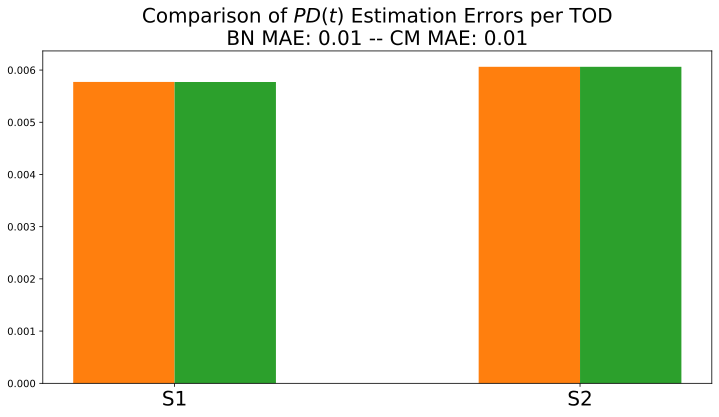

In [7]:
figs_pd = f'{OUTDIR}/figs_pd'
os.makedirs(figs_pd, exist_ok=True)

bn_err = []
cm_err = []

AUDITs = pickle.load(open(f"{OUTDIR}/AUDITs.pkl", "rb"))

for wp in WP:
    gts = []
    bayes_preds = []
    causal_preds = []
    wp_bin = 0
    
    bn = pyAgrum.loadBN(f"{OUTDIR}/CIE_{wp.value}.bifxml")
    cm = pyc.CausalModel(bn)
    dwp = pickle.load(open(f"{OUTDIR}/Ds.pkl", "rb"))[wp.value]
    _, _, midpoints_PD = get_info(dwp, AUDITs[wp.value], target_var)

    for idx_tod, tod in enumerate(TOD):
        df, D_tod = load_specific_D(INDIR, wp.value, tod.value)
        PD = np.mean(D_tod[target_var].values)
        gts.append(PD)
        
        # --- BN prediction ---
        ie = pyAgrum.VariableElimination(bn)
        bn_prior = ie.posterior(target_var)
        evidence = {intervention_var: idx_tod, "WP0": wp_bin}
        evidence_str = format_evidence_for_latex(evidence)
        ie.setEvidence(evidence)
        ie.makeInference()
        bn_posterior = ie.posterior(target_var)
        bn_posterior_values = bn_posterior.toarray()
        pred_bn = float(np.dot(bn_posterior_values, midpoints_PD))
        bayes_pred = (time/STEP)*pred_bn
                        
        # --- CausalModel prediction ---
        formula, adj, exp = pyc.causalImpact(cm, on=target_var, doing=intervention_var, knowing={"WP0"}, values=evidence)
        posterior_causal = adj.toarray()
        pred_causal = float(np.dot(posterior_causal, midpoints_PD))
        causal_pred = (time/STEP)*pred_causal
                        
        bayes_preds.append(bayes_pred)
        causal_preds.append(causal_pred)
        
    bn_errors = np.abs(np.array(bayes_preds)-np.array(gts))
    cm_errors = np.abs(np.array(causal_preds)-np.array(gts))
    
    bn_err.append(bn_errors)
    cm_err.append(cm_errors)

    # Define bar width and offsets
    bar_width = 0.25
    x_indexes = np.arange(len(TOD))

    # Plot bars for each category with offset
    plt.figure(figsize=(12, 6))
    plt.bar(x_indexes - bar_width, gts, width=bar_width, label="Ground Truth", color='tab:blue', alpha=1)
    plt.bar(x_indexes, bayes_preds, width=bar_width, label=r"BN: E[$\Delta R_B$|$R_V$,$C_S$]", color='tab:orange', alpha=1)
    plt.bar(x_indexes + bar_width, causal_preds, width=bar_width, label=r"CM: E[$\Delta R_B$|do($R_V$),$C_S$]", color='tab:green', alpha=1)
    plt.xticks(x_indexes, [f"{tod.value}" for tod in TOD], fontsize=plot_fontsize)  # Format x-axis labels
    plt.savefig(f"{figs_pd}/{wp.value}.png")
    plt.close()
    
    # plt.figure(figsize=(12, 6))
    # plt.bar(x_indexes - bar_width/2, bn_errors, width=bar_width, label=r"BN: E[$\Delta R_B$|$R_V$,$C_S$]", color='tab:orange', alpha=1)
    # plt.bar(x_indexes + bar_width/2, cm_errors, width=bar_width, label=r"CM: E[$\Delta R_B$|do($R_V$),$C_S$]", color='tab:green', alpha=1)
    # plt.xticks(x_indexes, [f"{tod.value}" for tod in TOD], fontsize=plot_fontsize)  # Format x-axis labels
    # plt.title(r"Comparison of $PD(t)$ " + f"Estimation Errors BN MAE: {np.mean(bn_errors, axis=0):.2f} -- CM MAE: {np.mean(cm_errors, axis=0):.2f}", fontdict={'fontsize': plot_fontsize})
    # plt.savefig(f"{figs_pd}/{wp.value}_err.png")
    # plt.close()
    
plt.figure(figsize=(12, 6))
plt.bar(x_indexes - bar_width/2, np.mean(bn_err, axis=0), width=bar_width, label=r"BN: E[$PD$|$TS$,$WP$]", color='tab:orange', alpha=1)
plt.bar(x_indexes + bar_width/2, np.mean(cm_err, axis=0), width=bar_width, label=r"CM: E[$PD$|do($TS$),$WP$]", color='tab:green', alpha=1)
plt.xticks(x_indexes, [f"{tod.value}" for tod in TOD], fontsize=plot_fontsize)  # Format x-axis labels
plt.title(r"Comparison of $PD(t)$ " + f"Estimation Errors per TOD\nBN MAE: {np.mean(np.mean(bn_err, axis=0), axis=0):.2f} -- CM MAE: {np.mean(np.mean(cm_err, axis=0), axis=0):.2f}", fontdict={'fontsize': plot_fontsize})
plt.show()

In [17]:
figs_pd = f'{OUTDIR}/figs_pd'
os.makedirs(figs_pd, exist_ok=True)

bn_err = []
cm_err = []

AUDITs = pickle.load(open(f"{OUTDIR}/AUDITs.pkl", "rb"))

DENSITY = {tod.value: {wp.value: 0 for wp in WP} for tod in TOD}

for idx_tod, tod in enumerate(TOD):
    gts = []
    bayes_preds = []
    causal_preds = []
    wp_bin = 0
    
    for wp in WP:
        bn = pyAgrum.loadBN(f"{OUTDIR}/CIE_{wp.value}.bifxml")
        cm = pyc.CausalModel(bn)
        dwp = pickle.load(open(f"{OUTDIR}/Ds.pkl", "rb"))[wp.value]
        _, _, midpoints_PD = get_info(dwp, AUDITs[wp.value], target_var)
        
        df, D_tod = load_specific_D(INDIR, wp.value, tod.value)
        PD = np.mean(D_tod[target_var].values)
        gts.append(PD)
        
        # --- BN prediction ---
        ie = pyAgrum.VariableElimination(bn)
        bn_prior = ie.posterior(target_var)
        evidence = {intervention_var: idx_tod, "WP0": wp_bin}
        evidence_str = format_evidence_for_latex(evidence)
        ie.setEvidence(evidence)
        ie.makeInference()
        bn_posterior = ie.posterior(target_var)
        bn_posterior_values = bn_posterior.toarray()
        pred_bn = float(np.dot(bn_posterior_values, midpoints_PD))
        bayes_pred = (time/STEP)*pred_bn
                        
        # --- CausalModel prediction ---
        formula, adj, exp = pyc.causalImpact(cm, on=target_var, doing=intervention_var, knowing={"WP0"}, values=evidence)
        posterior_causal = adj.toarray()
        pred_causal = float(np.dot(posterior_causal, midpoints_PD))
        causal_pred = (time/STEP)*pred_causal
                        
        bayes_preds.append(bayes_pred)
        causal_preds.append(causal_pred)
        DENSITY[tod.value][wp.value] = PD
    bn_errors = np.abs(np.array(bayes_preds)-np.array(gts))
    cm_errors = np.abs(np.array(causal_preds)-np.array(gts))
    
    bn_err.append(bn_errors)
    cm_err.append(cm_errors)

    # Define bar width and offsets
    bar_width = 0.25
    x_indexes = np.arange(len(WP))

    # Plot bars for each category with offset
    plt.figure(figsize=(12, 6))
    plt.title(f"People Density Scenario = {tod.value}")
    plt.barh(x_indexes+bar_width/2, gts, color='tab:red', alpha=1, label="Ground Truth", height=bar_width)
    plt.barh(x_indexes-bar_width/2, causal_preds, color='tab:blue', alpha=1, label="Causal Model", height=bar_width)
    plt.yticks(x_indexes, [f"{wp.value}" for wp in WP], fontsize=11)  # Format x-axis labels
    plt.legend()
    plt.savefig(f"{figs_pd}/{tod.value}.png")
    plt.close()

Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/robot_postprocess/csv/S1
Loading : /home/lcastri/git/PeopleFlow/utilities_ws/sr

Checking Line of Sight: 100%|██████████| 406/406 [00:07<00:00, 52.19it/s]


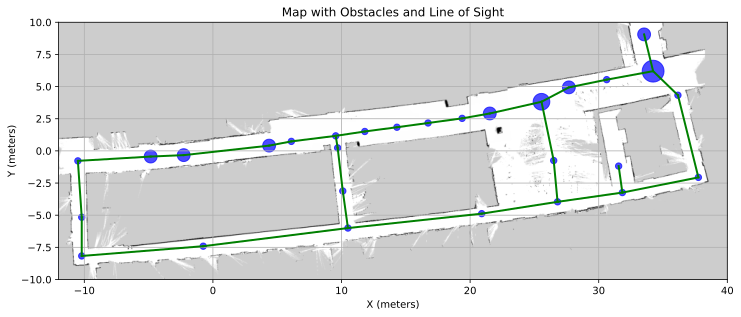

In [9]:
import os
import xml.etree.ElementTree as ET
import networkx as nx
import matplotlib.pyplot as plt
import yaml
import matplotlib.image as mpimg
from shapely.geometry import Point, LineString
import pickle
from matplotlib.patches import Circle
import math
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

def line_of_sight(ax, wp1, wp2, obstacles, waypoints, doors):
    """
    Function to check if the line between two points intersects any obstacles

    Args:
        ax: plot's axes (not used in multiprocessing)
        wp1 (tuple): waypoint 1
        wp2 (tuple): waypoint 2
        obstacles (list): obstacle coordinates
        waypoints (list): other waypoints
        doors (list): doors

    Returns:
        (bool, LineString/None): Line of sight status and the LineString object if valid
    """
    line = LineString([wp1, wp2])
    
    for obstacle in obstacles:
        if line.distance(Point(obstacle)) < 0.1:
            return False, None

    for wp in waypoints:
        waypoint_point = Point(wp[1], wp[2])
        waypoint_radius = wp[3]
        waypoint_circle = waypoint_point.buffer(waypoint_radius)
        if line.intersects(waypoint_circle):
            return False, None

    for door in doors:
        door_point = Point(door[1], door[2])
        if door_point == Point(wp1[0], wp1[1]) or door_point == Point(wp2[0], wp2[1]):
            continue
        if line.distance(door_point) < 0.75:
            return False, None

    return True, line


def line_of_sight_task(args):
    """Helper function for multiprocessing."""
    ax, wp1, wp2, obstacles, waypoints, doors = args
    return line_of_sight(ax, wp1, wp2, obstacles, waypoints, doors)


# Initialize ROS node
SCENARIO = "/home/lcastri/git/PeopleFlow/HRISim_docker/HRISim/waypoint_manager/waypoint_publisher/scenario/INB-3floor"
MAP_NAME = "/home/lcastri/git/PeopleFlow/HRISim_docker/HRISim/robot/maps/INB-3floor"
RES_DIR = "/home/lcastri/git/PeopleFlow/HRISim_docker/HRISim/waypoint_manager/graph_creator/graph"

# Create directory for results
scenario_name = SCENARIO.split("/")[-1]
res_dir = os.path.join(RES_DIR, scenario_name)
os.makedirs(res_dir, exist_ok=True)
tree = ET.parse(SCENARIO + '.xml')
root = tree.getroot()

# Extract waypoints
waypoints = []
doors = []
for waypoint in root.findall('waypoint'):
    wp_id = waypoint.get('id')
    x = float(waypoint.get('x'))
    y = float(waypoint.get('y'))
    r = float(waypoint.get('r'))
    waypoints.append((wp_id, x, y, r))
    
with open(os.path.join(MAP_NAME, 'map.yaml'), 'r') as yaml_file:
    map_info = yaml.safe_load(yaml_file)

# Load map image
map_image = mpimg.imread(os.path.join(MAP_NAME, 'submap_0.pgm'))

# Get resolution and origin from YAML
resolution = map_info['resolution']
origin_x, origin_y = map_info['origin'][:2]

# Extract obstacles
obstacle_threshold = 10
obstacle_mask = map_image < obstacle_threshold

# Calculate real-world coordinates of obstacles
obstacle_coordinates = []
for y in range(map_image.shape[0]):
    for x in range(map_image.shape[1]):
        if obstacle_mask[y, x]:
            x_real = origin_x + x * resolution
            y_real = origin_y + (map_image.shape[0] - y - 1) * resolution
            obstacle_coordinates.append((x_real, y_real))

# Prepare plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(-12, 40)  # Replace with your desired x-axis limits
ax.set_ylim(-10, 10)  # Replace with your desired y-axis limits
ax.imshow(map_image, extent=(origin_x, origin_x + map_image.shape[1] * resolution, 
                             origin_y, origin_y + map_image.shape[0] * resolution), cmap='gray')

# Add waypoints to graph and plot
G = nx.Graph()
for wp in waypoints:
    circle_patch = Circle((wp[1], wp[2]), radius=wp[3], alpha=0.7, color='b')
    ax.add_patch(circle_patch)
    G.add_node(wp[0], pos=(wp[1], wp[2]), radius=wp[3])

# Parallelize line-of-sight checks
tasks = []
for i, wp1 in enumerate(waypoints):
    for j, wp2 in enumerate(waypoints):
        if i < j:
            other_waypoints = waypoints[:i] + waypoints[i+1:j] + waypoints[j+1:]  # Exclude wp1 and wp2
            tasks.append((None, (wp1[1], wp1[2]), (wp2[1], wp2[2]), obstacle_coordinates, other_waypoints, doors))

lines_of_sight = []
with Pool(processes=cpu_count()) as pool:
    for result in tqdm(pool.imap(line_of_sight_task, tasks), total=len(tasks), desc="Checking Line of Sight"):
        lines_of_sight.append(result)

# Add edges to graph
for ((wp1_id, wp1_x, wp1_y, wp1_r), (wp2_id, wp2_x, wp2_y, wp2_r)), (exists, line) in zip(
    [(wp1, wp2) for i, wp1 in enumerate(waypoints) for wp2 in waypoints[i+1:]],
    lines_of_sight):
    if exists:
        x_values, y_values = line.xy
        ax.plot(x_values, y_values, 'g-', linewidth=2)
        G.add_edge(wp1_id, wp2_id, weight=math.sqrt((wp1_x - wp2_x)**2 + (wp1_y - wp2_y)**2))

# Customize plot
ax.set_title('Map with Obstacles and Line of Sight')
ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')
plt.grid(True)
# plt.savefig(os.path.join(res_dir, "waypoint_with_map.png"))
plt.show()

Checking Line of Sight: 100%|██████████| 406/406 [00:07<00:00, 56.59it/s]


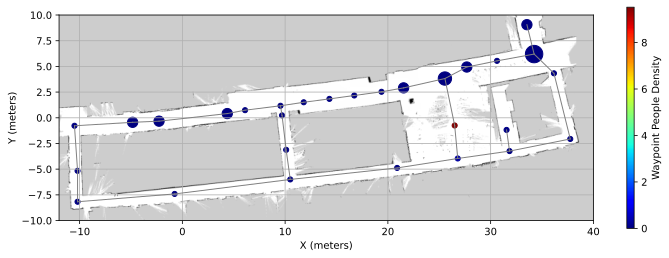

In [20]:
import os
import xml.etree.ElementTree as ET
import networkx as nx
import matplotlib.pyplot as plt
import yaml
import matplotlib.image as mpimg
from shapely.geometry import Point, LineString
from matplotlib.patches import Circle
import math
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import random # Added for dummy data generation
import matplotlib.cm as cm # Added for colormaps
import matplotlib.colors as mcolors # Added for color normalization




def line_of_sight(ax, wp1, wp2, obstacles, waypoints, doors):
    """
    Function to check if the line between two points intersects any obstacles

    Args:
        ax: plot's axes (not used in multiprocessing)
        wp1 (tuple): waypoint 1
        wp2 (tuple): waypoint 2
        obstacles (list): obstacle coordinates
        waypoints (list): other waypoints
        doors (list): doors

    Returns:
        (bool, LineString/None): Line of sight status and the LineString object if valid
    """
    line = LineString([wp1, wp2])
    
    for obstacle in obstacles:
        if line.distance(Point(obstacle)) < 0.1:
            return False, None

    for wp in waypoints:
        waypoint_point = Point(wp[1], wp[2])
        waypoint_radius = wp[3]
        waypoint_circle = waypoint_point.buffer(waypoint_radius)
        if line.intersects(waypoint_circle):
            return False, None

    for door in doors:
        door_point = Point(door[1], door[2])
        if door_point == Point(wp1[0], wp1[1]) or door_point == Point(wp2[0], wp2[1]):
            continue
        if line.distance(door_point) < 0.75:
            return False, None

    return True, line


def line_of_sight_task(args):
    """Helper function for multiprocessing."""
    ax, wp1, wp2, obstacles, waypoints, doors = args
    return line_of_sight(ax, wp1, wp2, obstacles, waypoints, doors)


# Initialize ROS node
SCENARIO = "/home/lcastri/git/PeopleFlow/HRISim_docker/HRISim/waypoint_manager/waypoint_publisher/scenario/INB-3floor"
MAP_NAME = "/home/lcastri/git/PeopleFlow/HRISim_docker/HRISim/robot/maps/INB-3floor"
RES_DIR = "/home/lcastri/git/PeopleFlow/HRISim_docker/HRISim/waypoint_manager/graph_creator/graph"
DENS = 'S2'

# Create directory for results
scenario_name = SCENARIO.split("/")[-1]
res_dir = os.path.join(RES_DIR, scenario_name)
os.makedirs(res_dir, exist_ok=True)
tree = ET.parse(SCENARIO + '.xml')
root = tree.getroot()

# Extract waypoints
waypoints = []
doors = []
for waypoint in root.findall('waypoint'):
    wp_id = waypoint.get('id')
    x = float(waypoint.get('x'))
    y = float(waypoint.get('y'))
    r = float(waypoint.get('r'))
    waypoints.append((wp_id, x, y, r))
    
with open(os.path.join(MAP_NAME, 'map.yaml'), 'r') as yaml_file:
    map_info = yaml.safe_load(yaml_file)

# Load map image
map_image = mpimg.imread(os.path.join(MAP_NAME, 'submap_0.pgm'))

# Get resolution and origin from YAML
resolution = map_info['resolution']
origin_x, origin_y = map_info['origin'][:2]

# Extract obstacles
obstacle_threshold = 10
obstacle_mask = map_image < obstacle_threshold

# Calculate real-world coordinates of obstacles
obstacle_coordinates = []
for y in range(map_image.shape[0]):
    for x in range(map_image.shape[1]):
        if obstacle_mask[y, x]:
            x_real = origin_x + x * resolution
            y_real = origin_y + (map_image.shape[0] - y - 1) * resolution
            obstacle_coordinates.append((x_real, y_real))

# Prepare plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(-12, 40)  # Replace with your desired x-axis limits
ax.set_ylim(-10, 10)  # Replace with your desired y-axis limits
ax.imshow(map_image, extent=(origin_x, origin_x + map_image.shape[1] * resolution, 
                             origin_y, origin_y + map_image.shape[0] * resolution), cmap='gray')

heat_values = list(DENSITY[DENS].values())
norm = mcolors.Normalize(vmin=min(heat_values), vmax=max(heat_values))
cmap = plt.get_cmap('jet')

# Add waypoints to graph and plot
G = nx.Graph()

# Parallelize line-of-sight checks
tasks = []
for i, wp1 in enumerate(waypoints):
    for j, wp2 in enumerate(waypoints):
        if i < j:
            other_waypoints = waypoints[:i] + waypoints[i+1:j] + waypoints[j+1:]  # Exclude wp1 and wp2
            tasks.append((None, (wp1[1], wp1[2]), (wp2[1], wp2[2]), obstacle_coordinates, other_waypoints, doors))

lines_of_sight = []
with Pool(processes=cpu_count()) as pool:
    for result in tqdm(pool.imap(line_of_sight_task, tasks), total=len(tasks), desc="Checking Line of Sight"):
        lines_of_sight.append(result)

# Add edges to graph
for ((wp1_id, wp1_x, wp1_y, wp1_r), (wp2_id, wp2_x, wp2_y, wp2_r)), (exists, line) in zip(
    [(wp1, wp2) for i, wp1 in enumerate(waypoints) for wp2 in waypoints[i+1:]],
    lines_of_sight):
    if exists:
        x_values, y_values = line.xy
        ax.plot(x_values, y_values, color='gray', linestyle='-', linewidth=1)
        G.add_edge(wp1_id, wp2_id, weight=math.sqrt((wp1_x - wp2_x)**2 + (wp1_y - wp2_y)**2))
        
        
for wp in waypoints:
    wp_id, x, y, r = wp
    
    # Get the "heat" value for the current waypoint from your dictionary.
    # Default to 0 if the waypoint ID is not in the dictionary.
    heat_value = DENSITY[DENS][wp_id]
    
    # Use the colormap and normalizer to get the appropriate color.
    color = cmap(norm(heat_value))
    
    # Use the generated color for the circle. The line you wanted to change is below.
    circle_patch = Circle((x, y), radius=r, alpha=1, color=color)
        
    ax.add_patch(circle_patch)
    G.add_node(wp_id, pos=(x, y), radius=r)

# Customize plot
ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')
plt.grid(True)

# 3. Add a colorbar to the plot to act as a legend for the heatmap.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, aspect=30)
cbar.set_label('Waypoint People Density')

plt.show()